# Predicting Heart Disease

We plan on utlizing the dataset compiled by FEDESORIANO and available via [kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) to predict the likelihood of a new patient having heart disease in the future.

In [1]:
#libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
disease_df = pd.read_csv('heart_disease_prediction.csv')

In [3]:
disease_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
disease_df.shape

(918, 12)

In [5]:
features = disease_df.drop('HeartDisease', axis=1)
target = disease_df['HeartDisease']

In [6]:
print("\nFeature columns:")
print(features.dtypes)
print("\nData types summary:")
print(features.dtypes.value_counts())


Feature columns:
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
dtype: object

Data types summary:
int64      5
object     5
float64    1
dtype: int64


It appears that we have 918 different observations and 11 features in the dataset. Of those 11 features, 7 are categorical. (`FastingsBS` and `HeartDisease` may have the dtype of int64, but are also categorical variables since they only take the values 0 and 1.)



In [7]:
target.value_counts(normalize=True)

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

In [8]:
#displaying descriptive statistics of dataset
disease_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


A few observations on the dataset:
* The average age of those included in this dataset is 53.5 years
    * With the oldest being 77 and the youngest being 28
* Most of those included in this study were diagnosed with heart disease
* `RestingBP` and `Cholesterol` have a minimum observations of 0
* The median `Cholesterol` observation is nearly 25 mm/dl higher than its mean, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.

At first glance, there doesn't seem to be any missing values in these columns, but there are some entries that are worth taking the time to verify. Namely, `RestingBP` and `Cholesterol`. 

Having a resting blood pressure of zero is unlikely. At least, in a living participant. Is it even possible to have a zero cholesterol reading? This will need to be verified before moving forward with our analysis.

As per the dataset description, Cholesterol contains the serum cholesterol values. And per the [American Heart Association](https://www.heart.org/en/health-topics/cholesterol/about-cholesterol/what-your-cholesterol-levels-mean), serum cholesterol:

>*is a composite of different measurements. Your total blood cholesterol is calculated by adding your HDL and LDL cholesterol levels, plus 20% of your triglyceride level.*

The above information is enough to let us know that a 0 value for serum cholesterol is unlikely.

Let's focus our attention to the categorical features next.

In [9]:
#number of missing values in all columns
disease_df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object

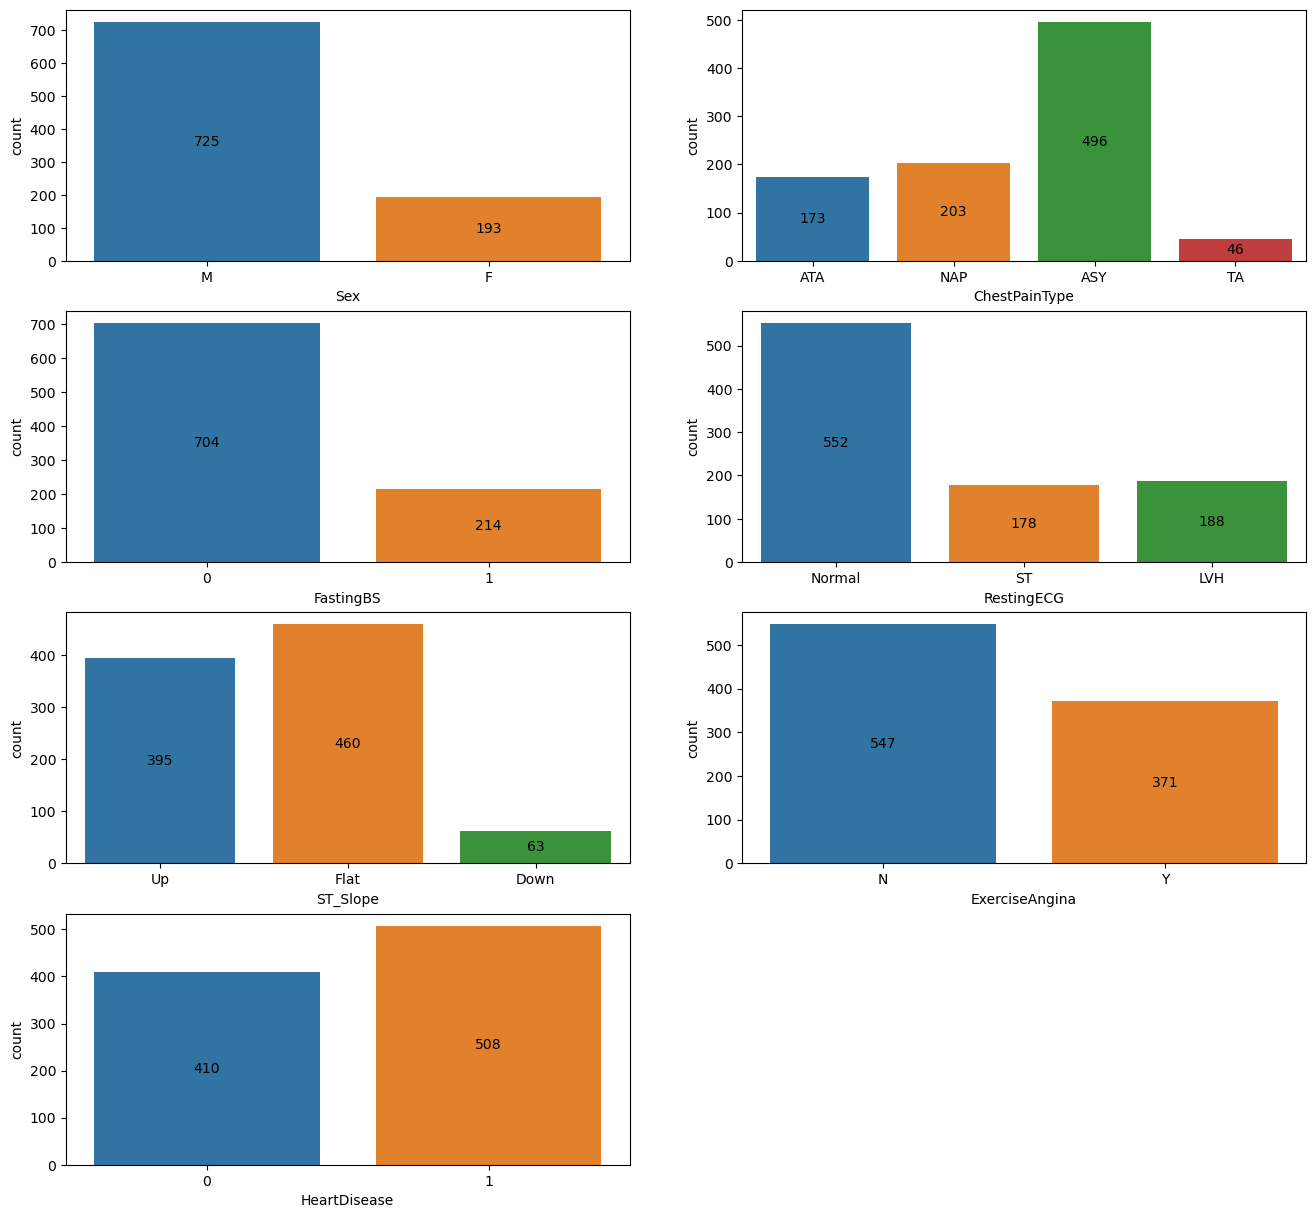

In [10]:
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ST_Slope', 'ExerciseAngina', 'HeartDisease']
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(cat_cols):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=disease_df[col], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")
        #uncomment below if wishing to include percentages in bar labels
        #ax.bar_label(container, label_type='edge', labels=[f'{(count/total)*100:.0f}%' for count in container.datavalues])

On the above charts:
* Males are disproportionaly overrepresented in the the dataset. Females make up less than a quarter of all observations

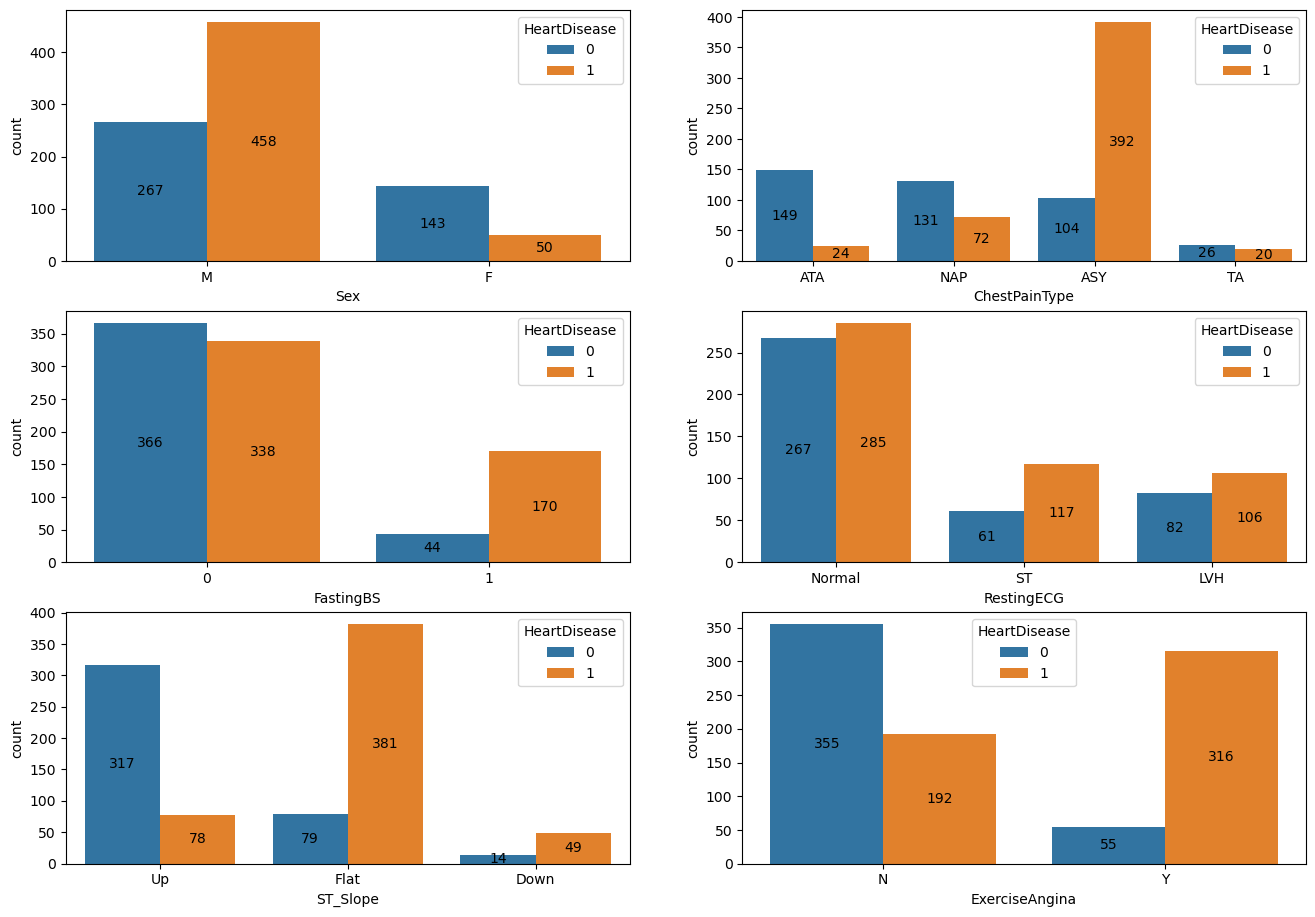

In [11]:
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ST_Slope', 'ExerciseAngina', 'HeartDisease']
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(cat_cols[:-1]):#all cat. cols., less HeartDisease
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=disease_df[col], hue=disease_df['HeartDisease'], ax=ax)#group by HeartDisease
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

In [12]:
grouped = disease_df.groupby('HeartDisease')
grouped['Sex'].count()

HeartDisease
0    410
1    508
Name: Sex, dtype: int64

* The majority of men in the study were diagnosed with heart disease.
    * Men: ~63% diagnosed with heart disease
    * Women: ~74% of women were *not* diagnosed with heart disease
* It would seem those reporting asymptomatic chest pain (e.i., no upper chest pain) happen to be the ones most likely to be diagnosed with heart disease.
    * With the above, we can caution that those who have no upper body chest pain, yet get diagnosed with heart disease may have gotten screened due to other symptoms not entered in this dataset.
    * It goes to show that screening for heart disease is a good idea, regardless of any obvious symptoms a patient may report
* Out of all the features in these observations, having a flat ST slope seems to be the most indicative of heart disease diagnoses.
    * The following image should prove illuminating as far understanding this feature:
    ![ECG ST Slopes](ST-segment-depression-upsloping-downsloping-horizontal.png "ECG ST Slopes")
    * In short, those who have ST slopes most similar to one seen on the right (horizontal) are more likely to be diagnosed with heart disease.



[Optional] Explore any groupings and/or visualizations of the data as you see fit. For example:

What percentage of patients with heart disease are male and over 50 years old?
What is the median age of patients who were diagnosed with heart disease?

## Data Cleaning

Now we need to move on to cleaning parts of this dataset. Even though we don't see missing values in any of the observations, there were a couple oddities where columns had `0` values entered. Having a `0` entry in these columns doesn't make sense. 

Our options:
1. Remove those rows entirely if their frequency of occurence is low
2. Impute the `0` entries with the median value of that column
    - Or, the median value of the column grouped by `HeartDisease`
    
Let's see just how many `0` entries we are dealing with both columns.

In [13]:
disease_df[disease_df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [14]:
disease_df[disease_df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [15]:
172/918

0.18736383442265794

`RestingBP` has only one `0` entry. It would be safe to exclude it from the dataset moving forward.

There are a total of 172 `0` entries in the `Cholesterol` column, which makes up nearly 19% of the entire dataset. We can't remove such a large portion of the dataset.

Let's see what would happen if we were to replace these `0` entries with the median values of `Cholesterol` given whether they did or did not have heart disease.

For the group of people diagnosed with heart disease:
`0` cholesterol entries will be replaced with this groups median cholesterol value

For the group of people diagnosed with not having heart disease:
`0` cholesterol entries will be replaced with this groups median cholesterol value

In [16]:
#copying the original dataset
cleaned_df = disease_df.copy()

#only include non-zero RestingBP observations
cleaned_df = cleaned_df[cleaned_df['RestingBP'] != 0]

In [17]:
tagged_index = [x for x in cleaned_df[cleaned_df['Cholesterol'] == 0].index]

In [18]:
print(len(tagged_index))

171


In [19]:
heart_disease_mask = cleaned_df['HeartDisease']==0

In [20]:
#where cleaned_df row does have heart disease 
chol_with_hd = cleaned_df.loc[~heart_disease_mask, 'Cholesterol']

#where cleaned_df row does NOT have heart disease 
chol_without_hd = cleaned_df.loc[heart_disease_mask, 'Cholesterol']

In [21]:
#replacing 0 values with median of cholesterol for observations where there is no heart disease
cleaned_df.loc[heart_disease_mask, 'Cholesterol'] = chol_without_hd.replace(to_replace=0, value=chol_without_hd.median())

#replacing 0 values with median of cholesterol for observations where there is heartdisease
cleaned_df.loc[~heart_disease_mask, 'Cholesterol'] = chol_with_hd.replace(to_replace=0, value=chol_with_hd.median())                                                                          

In [22]:
cleaned_df[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


The minimum values have indeed changed. Now to move and start selecting features for our model.

## Feature Selection

Now that we've cleaned our data, we can select features for our model. Thanks to our EDA and a general understanding of the features, we can identify some of the features that we could start with:

- `Age`
- `Sex`
- `ChestPainType`
- `Cholesterol`
- `FastingBS`

In [23]:
cleaned_df = pd.get_dummies(cleaned_df, drop_first=True)

In [24]:
cleaned_df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


<AxesSubplot:>

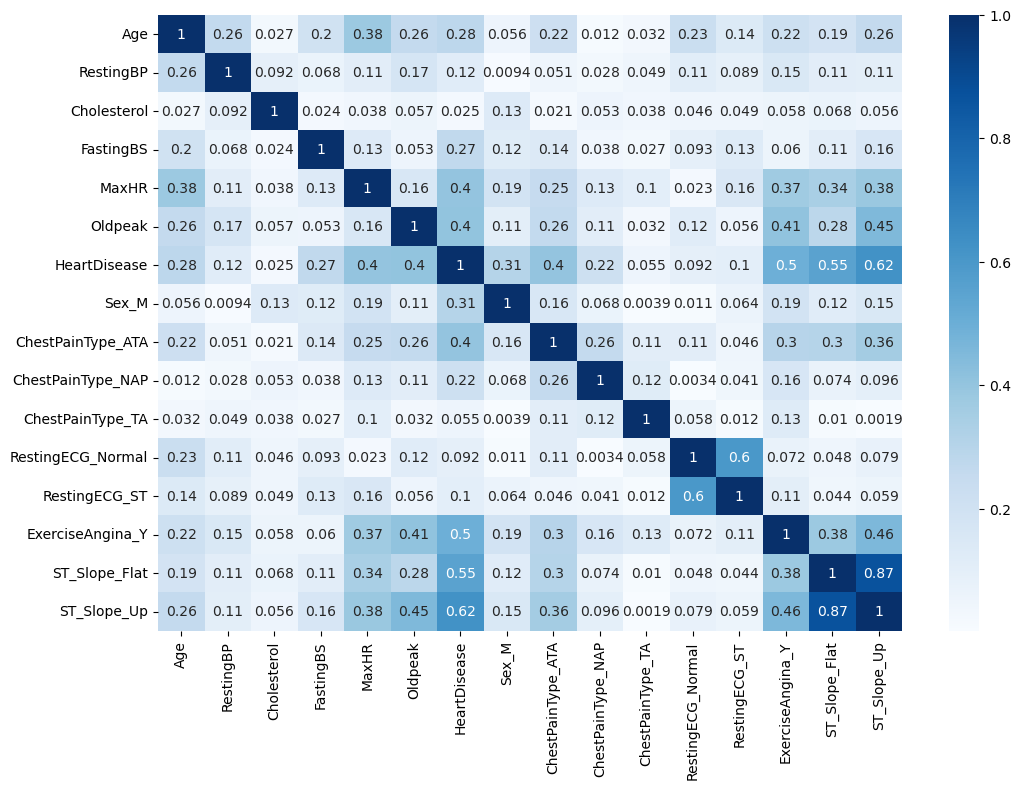

In [25]:
#pearson's correlation heat map
correlations = abs(cleaned_df.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="Blues")

<AxesSubplot:>

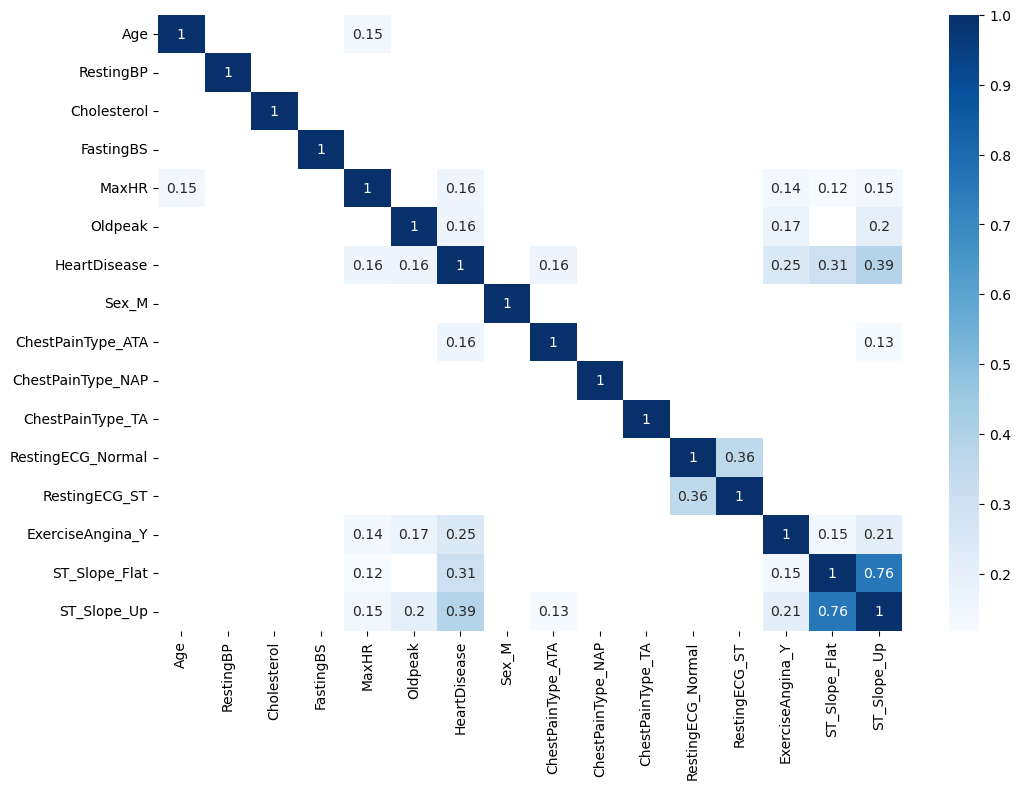

In [31]:
correlations = abs(cleaned_df.corr())**2
plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations >.1], annot=True, cmap="Blues")

In [44]:
#list correlations of features to HeartDisease
correlations['HeartDisease'].sort_values(ascending=False).iloc[1:].head(5)#iloc[1:] skips HeartDisease-to-HeartDisease corr

ST_Slope_Up          0.386688
ST_Slope_Flat        0.306584
ExerciseAngina_Y     0.245510
Oldpeak              0.162924
ChestPainType_ATA    0.161346
Name: HeartDisease, dtype: float64

From the correlation heatmap, the following features appear to be positively correlated (correlation coefficient > .1) to `HeartDisease`:
1. ST_Slope_Up
2. ST_Slope_Flat
3. ExerciseAngina_Y
4. Oldpeak
5. ChestPainType_ATA

The R<sup>2</sup> threshold of 0.1 was made based on filtering for the top 5 or so correlary features.

After narrowing down the features which might be relevant, we can create and train multiple models using one of the those feature at a time.

## Building a Classifier
### Part 1
We'll need to split the dataset into training and validation sets. 80% of the dataset goes to our training set, and the remaining 20% goes to our validation set.

In [45]:
features = ['ST_Slope_Up', 'ST_Slope_Flat', 'ExerciseAngina_Y', 'Oldpeak', 'ChestPainType_ATA']
X = cleaned_df.drop(['HeartDisease'], axis=1)
y = cleaned_df['HeartDisease']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=417)

In [61]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k=3 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on ST_Slope_Up and with k=3 has an accuracy of 80.98%
The k-NN classifier trained on ST_Slope_Flat and with k=3 has an accuracy of 78.26%
The k-NN classifier trained on ExerciseAngina_Y and with k=3 has an accuracy of 71.20%
The k-NN classifier trained on Oldpeak and with k=3 has an accuracy of 70.65%
The k-NN classifier trained on ChestPainType_ATA and with k=3 has an accuracy of 44.02%


The best performing model was trained on the `ST_Slope_Up` feature, getting an accuracy score of nearly 81%.

The second best performing model was trained on the `ST_Slope_Flat` feature, registering an accuracy score of ~78%.

With an accuracy score of 44%, feature `ChestPainType_ATA` resulted in a model that perform worse that simple chance.

This training was done with a single feature at a time. Let's train a model on all of these feature together.

### Part 2: Multi-Feature

Before we can really get into training a model on all of these features together, we need to normalize the features first. Not all of the values are within the same range, so we will scale our data (only the selected features) to the range (0,1) before training our model.

In [64]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

In [65]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 83.15


The model's accuracy improved to 83.15%. Using all these features results in an improved model, but, let's see what parameters/hyperparameters might be optimal.

## Hyperparameter Tuning

Now that we have a reasonably well-performing model, we can experiment with the parameters and hyperparameters. We'll use `GridSearchCV` to search over those values.

In [66]:
X = cleaned_df.drop(['HeartDisease'], axis=1)
y = cleaned_df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=417)

features = ['ST_Slope_Up', 'ST_Slope_Flat', 'ExerciseAngina_Y', 'Oldpeak', 'ChestPainType_ATA'] 

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

In [68]:
#dictionary storing params and vals to be searched over
grid_params = {
    'n_neighbors': range(1,20),
    "metric": ["minkowski", "manhattan"]
}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [69]:
knn_grid.best_score_*100, knn_grid.best_params_

(83.48336594911939, {'metric': 'minkowski', 'n_neighbors': 11})

It looks like the best model had an accuracy of ~83.48% with 11 neighbors and Minkowski as the distance metric.

The accuracy of this model is only slightly better. Since `GridSearchCV` employs a cross-validation approach, it is reasonable to assume that this is a better estimate of how the model performs compared to our prior attempt.

We will evaluate our model on our test set now.

### Model Evaluation on Test Set

We'll now evaluate this model on our test set. We'll only transform the test set and not fit the scaler on it.

In [73]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f'Model accuracy on test set: {accuracy*100:.2f}%')

Model accuracy on test set: 83.15%


Having a lower accuracy score could mean that the model is overfitting. The model seemingly learns the details and noise in the training data to the extent that it negatively impacts the performance of the model in new data (like our test set). 

This means the model is not generelize well to unseen data.

In the context of K-Nearest Neighbors (KNN), this could happen if the number of neighbors (k) is too low. A lower k value means the model is more influenced by the noise in the training data. We might want to try increasing k or using other techniques to reduce overfitting, such as increasing the size of the  dataset, if possible, or applying regularization techniques.

This model could be help in real_world healthcare settings if time and resources are limited. Instead of screening for every possible indicator of heart disease, medical professionals can focus on only a handful and move forward with additional screening, if warranted. 

Again, this model is not perfect, but its over 83% accuracy score in succesfully determining the likelihood of a patient having heart disease is somewhat impressive. If anything, this could help spur more research in the marked features themselves. As in, what is it about observed ST slope behaviors that they so correlate with heart disease? 